# Ride Analysis

Our research questions are as follows:

- Does instructor affect output?
<br><i>Hypothesis: Olivia Amato is most difficult</i>

- Do warmup rides affect output?
<br><i>Hypothesis: They improve output</i>

- Does ride type affect output?
<br><i>Hypothesis: Yes, hardest being Climb and Intervals, and easiest being low impact</i>

- Does music type affect output? 
<br><i>Hypothesis: No difference across genres</i>

- Does ride length affect output?
<br><i>Hypothesis: Shorter rides increase output</i>

- Does time of day affect output? 
<br><i>Hypothesis: Worse in the early morning</i>


After answering the above, we will build a model to predict output for a given ride as well as increases in performance over time.

In [23]:
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

Before we begin, we start by cleaning the data:

- Remove all non-cycling workouts, and those with no output
- Label workouts with a warm up ride
- Extract and code the music genre
- Code rides by time of day
- Code rides by instructor

In [86]:
rides = pd.read_csv('user_workouts.csv')
rides = rides[(rides['Fitness Discipline'] == 'Cycling') & (rides['Total Output'] > 3) & (~rides['Title'].str.contains('Cool Down'))]
rides['had_warmup'] = rides.Title.str.contains('Warm Up').astype(int).shift(1).fillna(0).astype(int)
rides = rides[~rides.Title.str.contains('Warm Up')]

rides = rides.reset_index(drop=True).reset_index()

#rides['calories_per_hour'] = (rides['Calories Burned'] / rides['Length (minutes)']) * 60
# De-trending output
rides['baseline_avg_watts']= rides['Avg. Watts'].rolling(window=5).mean().shift(1).fillna(rides['Avg. Watts'].iloc[0])
rides['avg_watts_over_baseline'] = rides['Avg. Watts'] - rides['baseline_avg_watts']


rides['music_type'] = np.where(rides.Type == 'Music', rides.Title.str.extract(r'\d+ min\s(.*)\sRide$',expand=False), 'other_genre')
rides['music_type'] = np.where(rides.music_type.str.contains('Hip Hop'), 'Hip Hop', rides.music_type)
rides['music_type'] = np.where(rides.music_type.str.contains('Hip Hop'), 'Hip Hop', rides.music_type)
rides['music_type'] = np.where(rides.music_type.str.contains('Pop'), 'Pop', rides.music_type)
rides['music_type'] = np.where(rides.music_type.str.contains('Beyonce'), 'Pop', rides.music_type)
rides['music_type'] = np.where(rides.music_type.str.contains('Rock'), 'Rock', rides.music_type)
rides['music_type'] = np.where(rides.music_type == 'Dance Music', 'EDM', rides.music_type)
rides['music_type'] = np.where(rides.music_type == 'House', 'EDM', rides.music_type)
rides['music_type'] = np.where(rides.music_type.str.contains('Post Malone'), 'Hip Hop', rides.music_type)

rides['ride_time'] = pd.to_datetime(rides['Workout Timestamp'].str.replace(r'\s\([A-Z]{3}\)', ''))
rides['ride_hour'] = rides.ride_time.apply(lambda x: x.hour)
rides['ride_hour_string'] = np.where(rides.ride_hour.isin([3,4,5,6,7,8,9]), "early", "evening")
rides['ride_hour_string'] = np.where(rides.ride_hour.isin([10,11,12,13,14,15,16,17]), 'midday', rides['ride_hour_string'])

# rides['early'] = np.where(rides.ride_hour.isin([3,4,5,6,7,8,9]), 1, 0)
# rides['midday'] = np.where(rides.ride_hour.isin([10, 11, 12, 13, 14, 15, 16, 17]), 1, 0)
# rides['evening'] = np.where(rides.ride_hour.isin([18, 19, 20, 21, 22, 23, 0,1,2 ]), 1, 0)

instructor_counts = pd.DataFrame(rides.groupby('Instructor Name', as_index = False).size()).reset_index().rename(columns= {0:'ride_count'})
instructor_exclude = instructor_counts[instructor_counts.ride_count < 5]['Instructor Name'].to_list()
rides['clean_instructor'] = np.where(rides['Instructor Name'].isin(instructor_exclude), 'other_instructor', rides['Instructor Name'])

for each in ['clean_instructor', 'music_type', 'Type', 'ride_hour_string']:
    rides = pd.concat([rides, pd.get_dummies(rides[each])], axis=1)
    
instructors = rides['clean_instructor'].unique().tolist()
times = ['early', 'midday', 'evening']
genres = rides['music_type'].unique().tolist()
types = rides['Type'].unique().tolist()

### Does instructor affect output?

Our hypothesis appears to be supported! Olvia Amato brings the most energy expendenture over baseline. However, differing sample sizes should be noted.

In [3]:
rides[rides.clean_instructor != 'other_instructor'].groupby('clean_instructor', as_index=False).agg(
    {'index': 'count',
     'avg_watts_over_baseline': 'mean'}).sort_values(by='avg_watts_over_baseline', ascending=False).reset_index(
    drop=True).rename(columns={'clean_instructor': 'instructor','index':'ride_count'})

,instructor,ride_count,avg_watts_over_baseline
0,Olivia Amato,5,17.200000
1,Jess King,5,10.520000
2,Ally Love,16,7.450000
3,Kendall Toole,11,4.200000
4,Emma Lovewell,5,0.440000
5,Cody Rigsby,7,-0.714286
6,Alex Toussaint,48,-1.758333
7,Robin Arzon,5,-4.040000
8,Hannah Corbin,8,-4.800000
9,Tunde Oyeneyin,7,-7.228571


### Do warmup rides affect output?

Our hypothesis appears to be supported! Warmup rides appear to significantly improve energy expendenture over baseline. Again, the large sample size differences should be noted.

In [4]:
rides.groupby('had_warmup', as_index=False).agg(
    {'index': 'count',
     'avg_watts_over_baseline': 'mean'}).sort_values(by='avg_watts_over_baseline', ascending=False).reset_index(
    drop=True).rename(columns={'index':'ride_count'})

,had_warmup,ride_count,avg_watts_over_baseline
0,1,4,32.850000
1,0,123,1.017886


### Does ride type affect output?

Our hypothesis appears to be ! Ride type appears to significantly improve energy expendenture over baseline, with Power Zone, Climb, and Intervals increasing output the most.

In [5]:
rides.groupby('Type', as_index=False).agg(
    {'index': 'count',
     'avg_watts_over_baseline': 'mean'}).sort_values(by='avg_watts_over_baseline', ascending=False).reset_index(
    drop=True).rename(columns={'index':'ride_count'})

,Type,ride_count,avg_watts_over_baseline
0,Power Zone,3,29.133333
1,Climb,4,23.300000
2,Intervals,23,9.695652
3,Theme,18,2.322222
4,Music,69,2.307246
5,Beginner,1,-10.400000
6,Low Impact,9,-37.511111


### Does music type affect output?

Our hypothesis appears to be generally supported! Although EDM appears to improve output, most genres do not help nor hinder one way or the other.

In [6]:
rides.groupby('music_type', as_index=False).agg(
    {'index': 'count',
     'avg_watts_over_baseline': 'mean'}).sort_values(by='avg_watts_over_baseline', ascending=False).reset_index(
    drop=True).rename(columns={'index':'ride_count'})

,music_type,ride_count,avg_watts_over_baseline
0,EDM,4,12.050000
1,New Tracks,6,6.566667
2,Rock,2,5.700000
3,80s,2,5.200000
4,R&B,1,4.000000
5,2000s,11,2.963636
6,Pop,19,2.705263
7,other_genre,58,1.679310
8,2010s,1,0.600000
9,Hip Hop,17,-0.929412


### Does ride length affect output?

Our hypothesis appears to be generally supported! We will ignore the single 60 minute ride. Though our shortest rides have low output over baseline, half of these rides are 'Low Impact'. Our 15, 20 and 30 minute rides on average have output above baseline, while 45 minute rides have output below baseline. A negative relationship between ride length and output over baseline further confirms our hypothesis. 

In [18]:
rides.groupby('Length (minutes)', as_index=False).agg(
    {'index': 'count',
     'avg_watts_over_baseline': 'mean'}).sort_values(by='avg_watts_over_baseline', ascending=False).reset_index(
    drop=True).rename(columns={'index':'ride_count'})

,Length (minutes),ride_count,avg_watts_over_baseline
0,60,1,14.200000
1,20,24,9.500000
2,30,77,2.348052
3,15,4,1.150000
4,45,15,-4.186667
5,10,6,-18.033333


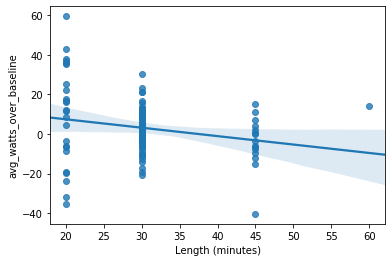

In [19]:
sns.regplot(x='Length (minutes)', y='avg_watts_over_baseline', data=rides[rides['Length (minutes)'] >=20])

In [8]:
rides[rides['Length (minutes)'] == 10].groupby('Type', as_index=False).agg(
    {'index': 'count'}).rename(columns={'index':'ride_count'})

,Type,ride_count
0,Climb,3
1,Low Impact,3


### Does time of day affect output?

Our hypothesis appears to be rejected! We tend to outperform early in the morining.

In [9]:
rides.groupby('ride_hour_string', as_index=False).agg(
    {'index': 'count',
    'avg_watts_over_baseline': 'mean'}).sort_values(by='avg_watts_over_baseline', ascending=False).reset_index(
    drop=True).rename(columns={'index':'ride_count'})

,ride_hour_string,ride_count,avg_watts_over_baseline
0,early,10,8.200000
1,evening,62,1.632258
2,midday,55,1.334545


## Modelling Next Ride Output

From the above analysis, we will build a model to predict the average and total output of an upcoming ride. We will use instructor, whether there was a warmup ride, ride length, ride type, and whether it was an early ride to predict output above or below baseline. We will then use the baseline from the previous 5 rides to predict total output.

In [100]:
def predict_next_ride(trainer,model, instructor,warmup, length, early, ride_type):
    if instructor not in instructors:
        print('Invalid Instructor')
        return {}
    if ride_type not in types:
        print('Invalid ride_type')
        return {}
    if type(warmup) != bool:
        print('warmup must be True or False')
        return {}
    if type(early) != bool:
        print('early must be True or False')
        return {}
    
    baseline = trainer[trainer['Length (minutes)'] == length].sort_values(by='ride_time').tail(5)['Avg. Watts'].mean()
    
    instructor_list = list(np.repeat(0, len(instructors)))
    instructor_index = instructors.index(instructor)
    instructor_list[instructor_index] = 1
    
    middle_list = [int(warmup),length,int(early)]
    
    type_list = list(np.repeat(0, len(types)))
    type_index = types.index(ride_type)
    type_list[type_index] = 1
    
    baseline_change_pred = model.predict([instructor_list + middle_list + type_list])[0]
    total_output_pred = ((baseline + baseline_change_pred)*length*60) / 1000
    
    return {'predicted_change_from_baseline':round(baseline_change_pred, 2),'predicted_total_output':round(total_output_pred, 2)}

In [80]:
#Predict Next Ride

train_cols = instructors + ['had_warmup', 'Length (minutes)','early'] + types
all_train = rides[train_cols]
all_y = rides['avg_watts_over_baseline']
model = RandomForestRegressor(n_estimators=100)
model.fit(rides_train, rides_y)

{'predicted_change_from_baseline': 9.37, 'predicted_total_output': 291.54}


In [91]:
#Sandbox
print(predict_next_ride(rides,model,instructor='Ally Love', warmup=False,length=60,early=False,ride_type='Theme'))

{'predicted_change_from_baseline': 8.71, 'predicted_total_output': 589.36}


In [83]:
def latest_rides_crossval(num_cv):
    train_cols = instructors + ['had_warmup', 'Length (minutes)','early'] + types
    tester = rides.tail(num_cv)
    rez_list = []
    for rowdict in tester.to_dict('records'):
        idx = rowdict['index']
        trainer = rides[rides['index'] < idx]
        rides_train = trainer[train_cols]
        rides_y = trainer['avg_watts_over_baseline']
        mymodel = RandomForestRegressor(n_estimators=100)
        mymodel.fit(rides_train, rides_y)

        test_instructor = rowdict['clean_instructor']
        test_warmup = bool(rowdict['had_warmup'])
        test_length = rowdict['Length (minutes)']
        test_early = bool(rowdict['early'])
        test_type = rowdict['Type']

        prediction = predict_next_ride(trainer,mymodel,test_instructor, test_warmup,test_length,test_early,test_type)
        actual = rowdict['Total Output']

        rez_list.append({'pred_index': idx, 
                         'instructor': test_instructor,
                         'had_warmup': test_warmup, 
                         'length': test_length,
                         'is_early': test_early, 
                         'ride_type': test_type, 
                         'predicted_total_output': prediction['predicted_total_output'], 
                         'observed_total_output': actual})


    return pd.DataFrame(rez_list)

In [101]:
latest_rides_crossval(10)

,pred_index,instructor,had_warmup,length,is_early,ride_type,predicted_total_output,observed_total_output
0,117,Emma Lovewell,False,10,False,Low Impact,54.77,66.0
1,118,Jess King,False,30,False,Music,298.73,270.0
2,119,Ally Love,False,60,False,Theme,NaN,560.0
3,120,Olivia Amato,False,30,False,Power Zone,324.26,241.0
4,121,Kendall Toole,False,45,False,Music,409.30,401.0
5,122,Alex Toussaint,False,30,False,Theme,265.32,269.0
6,123,Jess King,True,20,False,Intervals,229.39,191.0
7,124,Olivia Amato,False,20,False,Climb,215.42,230.0
8,125,Alex Toussaint,False,15,False,Music,88.63,142.0
9,126,Hannah Corbin,False,15,False,Intervals,135.42,162.0
